In [1]:
import gradio as gr
import openai
import base64
import time

/Users/guna_bb/anaconda3/envs/DB/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
openai.api_base = "https://868b-35-184-142-228.ngrok-free.app/v1"  # 또는 ngrok URL
openai.api_key = "EMPTY"  

In [3]:
try:
    models = openai.Model.list()
    print(models)
except Exception as e:
    print(f"Error: {e}")

{
  "object": "list",
  "data": [
    {
      "id": "llava-hf/llava-1.5-7b-hf",
      "object": "model",
      "created": 1732973629,
      "owned_by": "vllm",
      "root": "llava-hf/llava-1.5-7b-hf",
      "parent": null,
      "max_model_len": 4096,
      "permission": [
        {
          "id": "modelperm-5304181424ed4eed86fb888961e67018",
          "object": "model_permission",
          "created": 1732973629,
          "allow_create_engine": false,
          "allow_sampling": true,
          "allow_logprobs": true,
          "allow_search_indices": false,
          "allow_view": true,
          "allow_fine_tuning": false,
          "organization": "*",
          "group": null,
          "is_blocking": false
        }
      ]
    }
  ]
}


In [4]:
model = models.data[0].id


In [5]:
def encode_base64_content_from_file(image_path: str) -> str:
    """Encode a content retrieved from image_path to base64 format."""
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

In [6]:
def remove_image_url_from_history(history):
    for msg in history:
        # content가 리스트인 경우에만 처리
        if isinstance(msg.get("content"), list):
            # "type": "image_url"이 아닌 항목만 남김
            msg["content"] = [c for c in msg["content"] if c.get("type") != "image_url"]
    return history

In [7]:
def make_openai_msg(message,history):
  content = []
  if message["files"] is not None:
    history = remove_image_url_from_history(history)
    for x in message["files"]:
      image_url = f"data:image/jpeg;base64,{encode_base64_content_from_file(x)}"
      content.append({"type": "image_url",
                      "image_url":{"url": image_url}})
    if message["text"]:
      content.append({"type":"text",
                      "text": message["text"]})
    else:
      content.append({"type":"text",
                      "text":"이 사진에 대해 설명해주세요"})
    print({"role":"user",
          "content":content})
    new_history = history + [{"role":"user",
          "content":content}]
    return gr.update(value=new_history)
  else:
    print({"role": "user",
                "content": message["text"]})
    new_history = history + [{"role": "user",
                "content": message["text"]}]
    return gr.update(value=new_history)
  

In [8]:
def add_message(history, message):
    for x in message["files"]:
        history.append({"role": "user", "content": {"path": x}})
    if message["text"] is not None:
        history.append({"role": "user", "content": message["text"]})
    else: history.append({"role": "user", "content": "explain this image or picture"})
    return history, gr.MultimodalTextbox(value=None, interactive=False)

In [9]:
def bot(history: list,msg_history):
    
    chat_completion = openai.ChatCompletion.create(
        model=model,  # Replace with your model ID
        messages=msg_history,
        max_tokens=128,  # Configurable for more detailed responses
    )
    result = chat_completion.choices[0].message["content"]
    history.append({"role": "assistant", "content": ""})
    update_history = msg_history + [{"role": "assistant", "content":result}]
    print(update_history)
    for character in result:
        history[-1]["content"] += character
        time.sleep(0.05)
        yield history, gr.update(value=update_history)

In [10]:
def add_history(msg_history,message):
  new_message, new_history = make_openai_msg(message,msg_history)
  update_list = msg_history + [new_message]
  print(update_list)
  return gr.update(value=update_list)

In [11]:
with gr.Blocks() as demo:
  chatbot = gr.Chatbot(elem_id = "chatbot", bubble_full_width=False, type="messages")

  chat_input = gr.MultimodalTextbox(
    interactive=True,
    file_count="multiple",
    placeholder="메세지나 파일을 입력하세요",
    show_label=False,
  )
  json_output = gr.JSON(visible=False)
  msg_history = gr.JSON(visible=False,value=[{"role": "system", "content":"your are intelligent chatbot."}])

  
  user_msg = chat_input.submit(
    make_openai_msg, [chat_input,msg_history], msg_history
  )
  
  chat_msg = user_msg.then(
    add_message, [chatbot, chat_input], [chatbot,chat_input]
  )

  bot_msg = chat_msg.then(bot, [chatbot,msg_history], [chatbot,msg_history], api_name="bot_response")
  bot_msg.then(lambda: gr.MultimodalTextbox(interactive=True), None, [chat_input])

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


{'role': 'user', 'content': [{'type': 'text', 'text': '오케이 레츠고'}]}
[{'role': 'system', 'content': 'your are intelligent chatbot.'}, {'role': 'user', 'content': [{'type': 'text', 'text': '오케이 레츠고'}]}, {'role': 'assistant', 'content': '\n죄송합니다. 이 문장이 정확히 올바른 내용이 아닙니다. 앞으로의 대화에서 제가 가져야 할 항목을 알려주시겠습니까?'}]
{'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'explain this picture'}]}
[{'role': 'system', 'content': 'your are intelligent chatbot.'}, {'role': 'user', 'content': [{'type': 'text', 'text': '오케이 레츠고'}]}, {'role': 'assistant', 'content': '\n죄송합니다. 이 문장이 정확히 올바른 내용이 아닙니다. 앞으로의 대화에서 제가 가져야 할 항목을 알려주시겠습니까?'}, {'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'explain this picture'}]}, {'role': 'assistant', 'content': '\nThe image depicts a computer screen displaying a YouTube video. The video shows a cartoon character from an animated show, and it appears to be a short video clip. Th
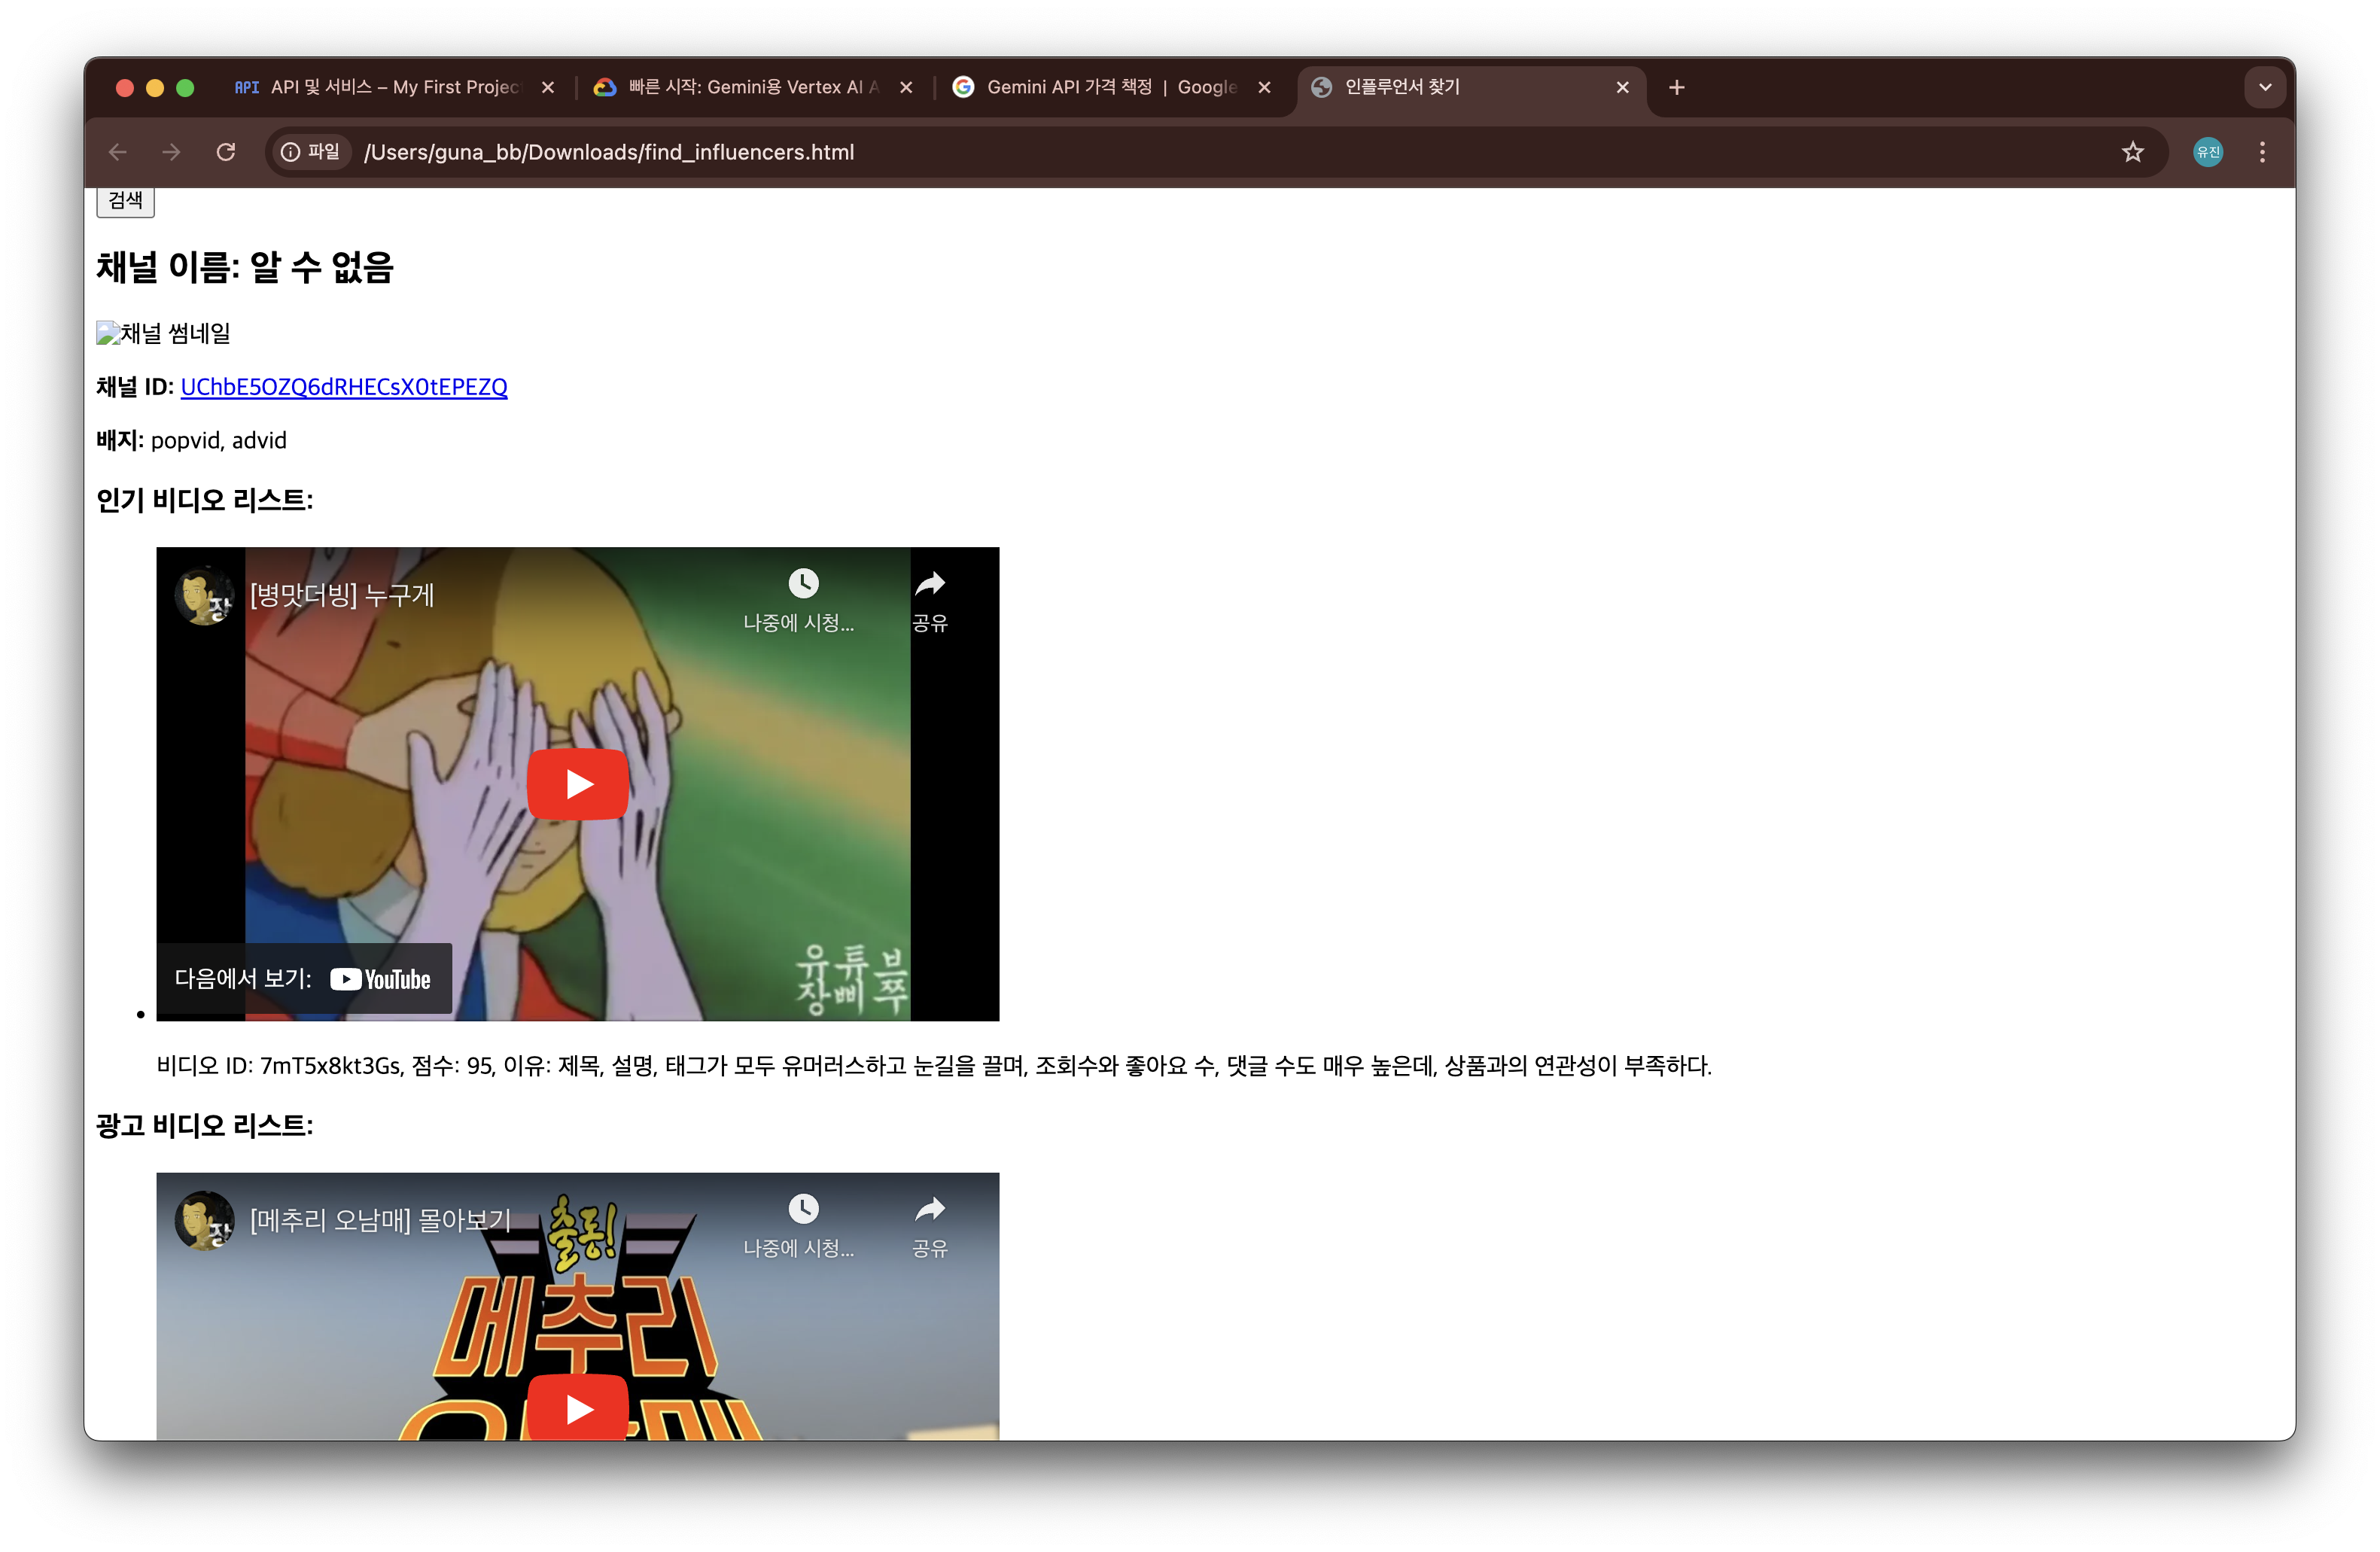
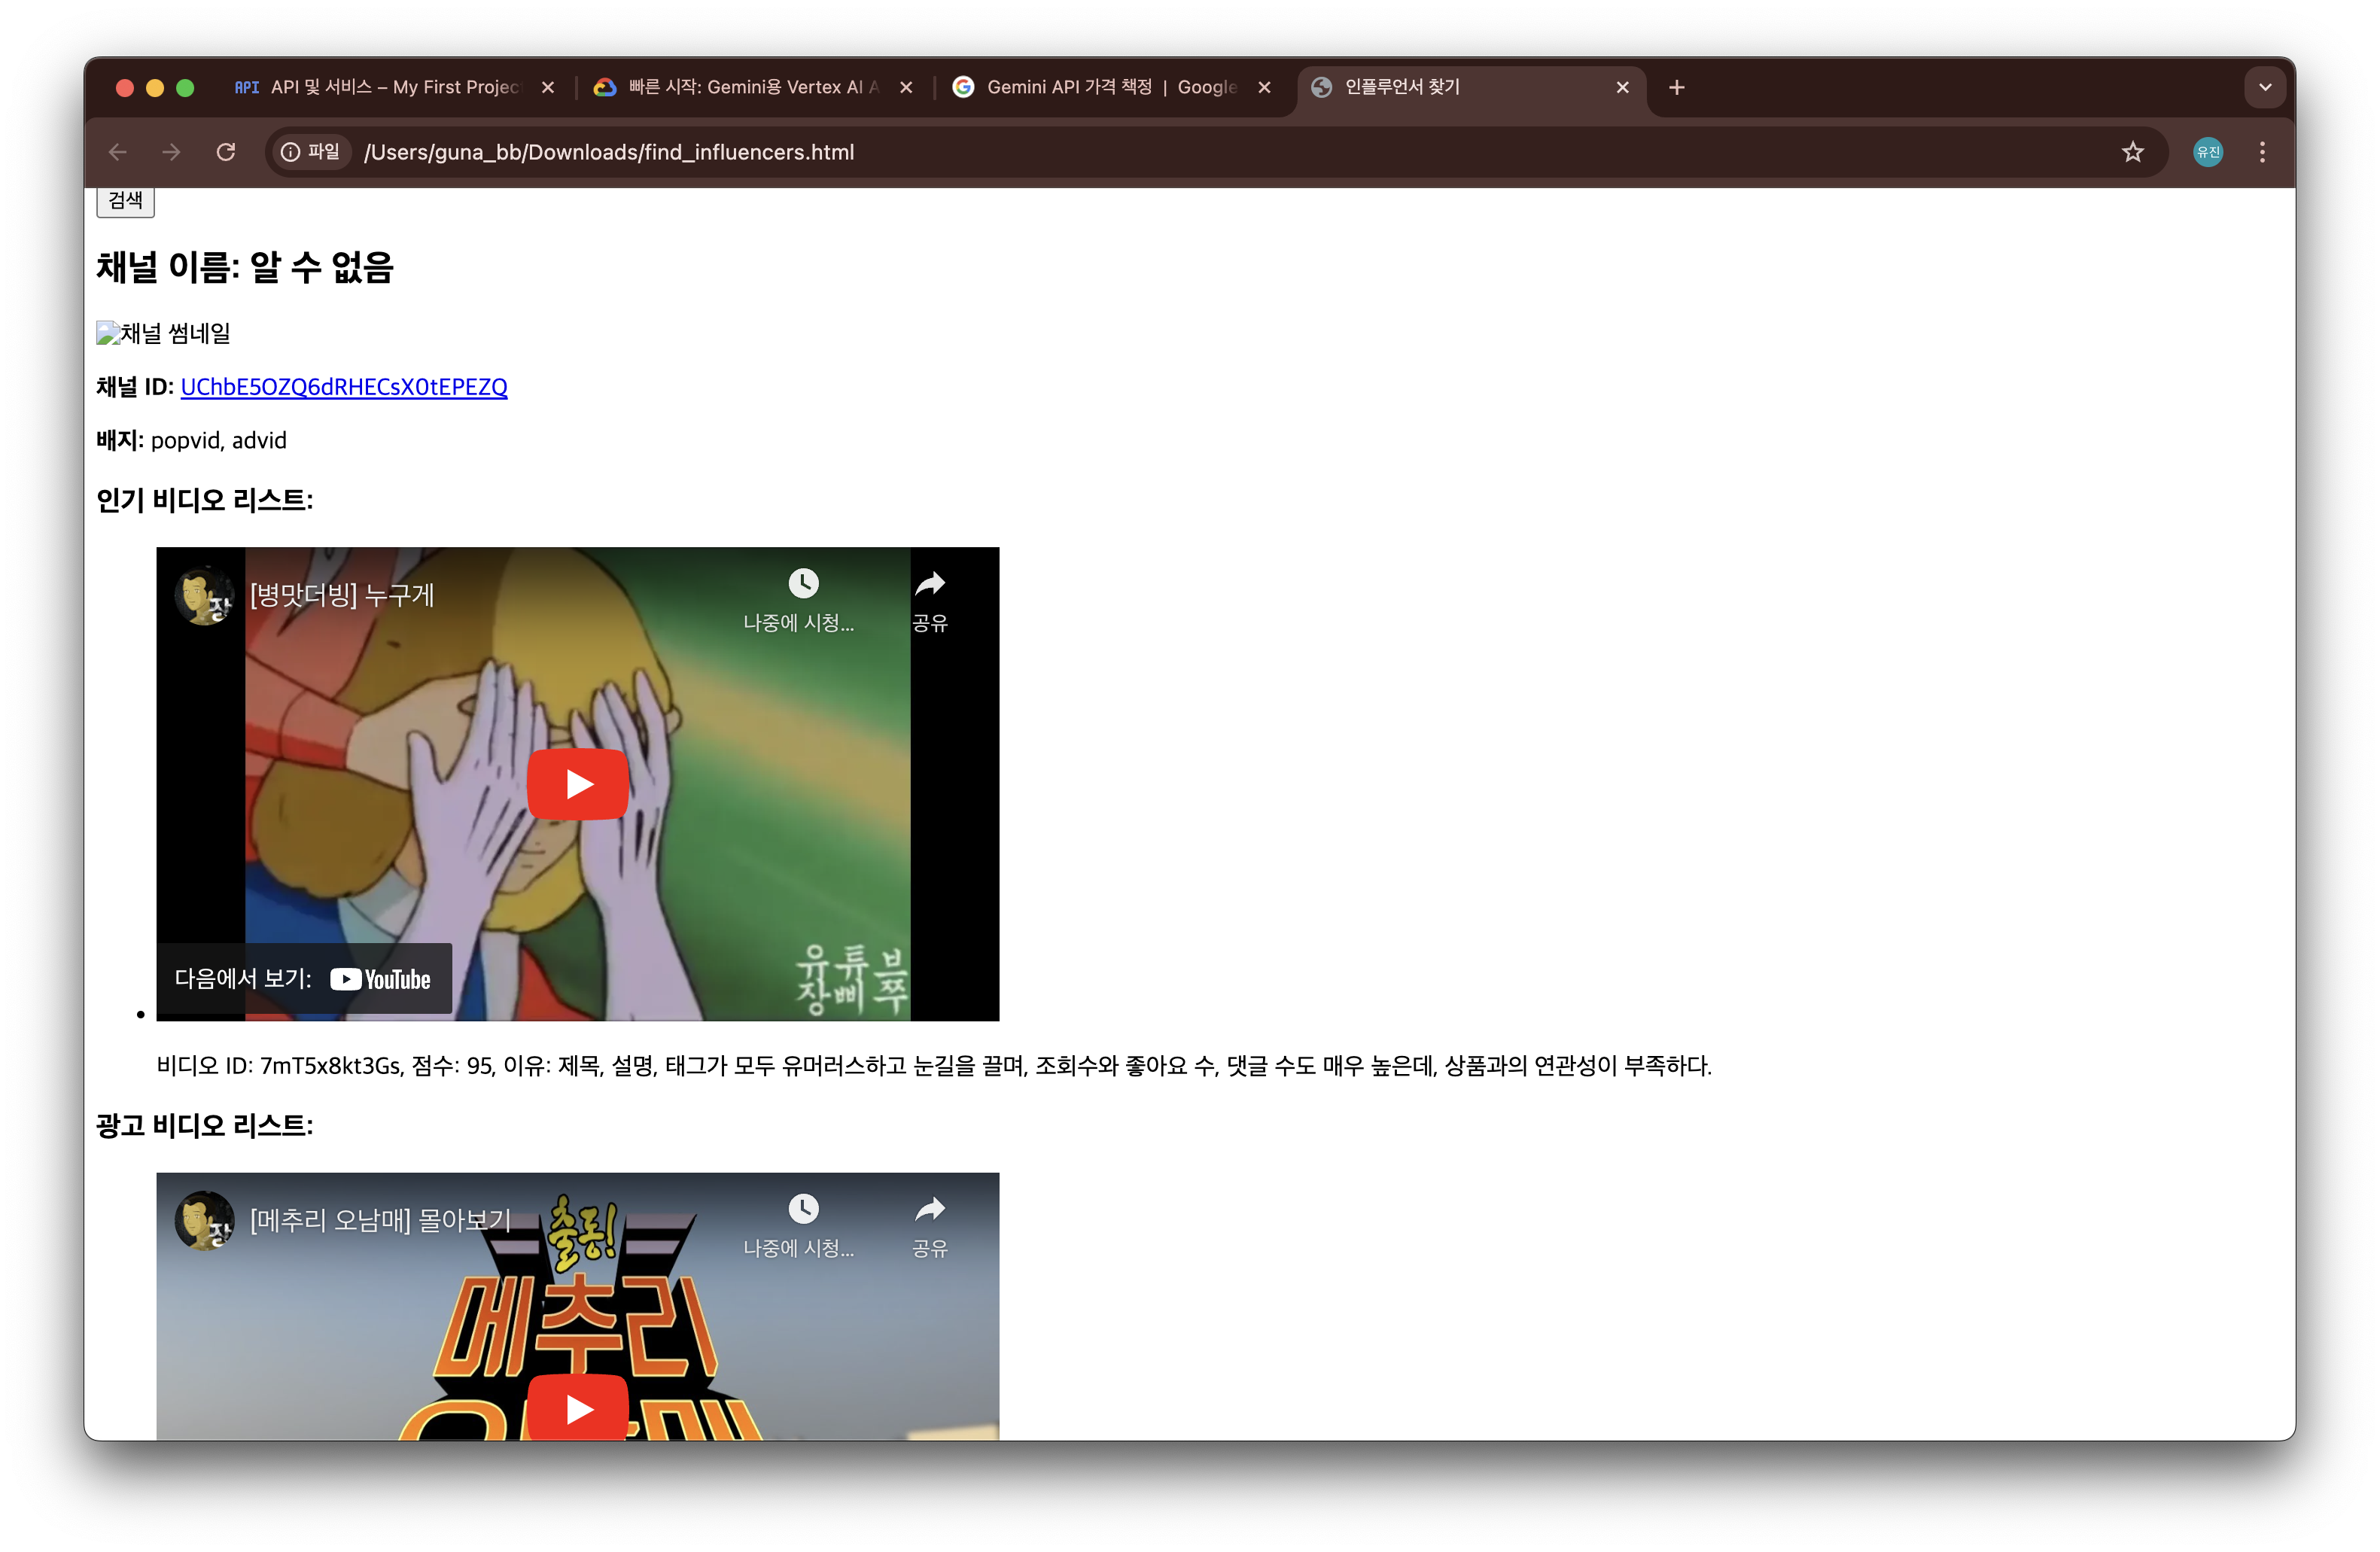
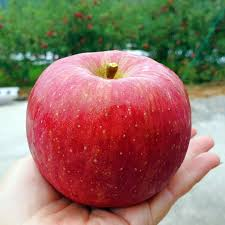
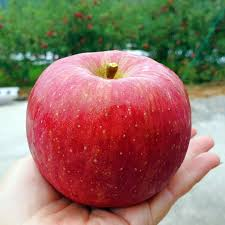

In [ ]:
demo.launch()